Train Epoch: 1 [0/360 (0%)]	Loss: 0.044091
Train Epoch: 1 [100/360 (28%)]	Loss: 0.037294
Train Epoch: 1 [200/360 (56%)]	Loss: 0.045891
Train Epoch: 1 [300/360 (83%)]	Loss: 0.051220
====> Epoch: 1 Average loss: 0.042796
====> Test set loss: 0.058523
0.042795994215541415 0.05852300777203507


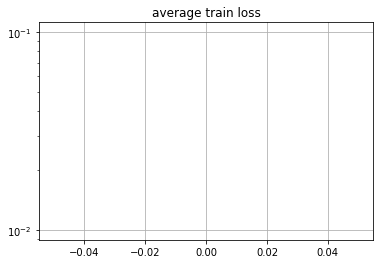

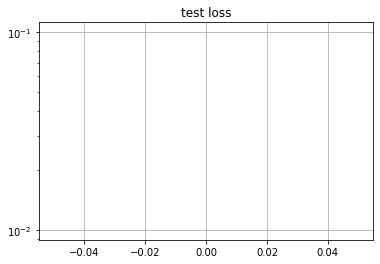

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models.data_loading import LightFieldDataset
from models.VAE import VAE
from models.Trainer import Trainer
from models.transformations import Brightness, Color_jitter, Contrast, Noice, RandomCrop 
import os

# new directory
res_folder = 'Ergebnisse'
os.makedirs(res_folder, exist_ok=True)
state_path = os.path.join(res_folder, 'model.pth')

# set parameters
in_params = {"batch_size": 5,
        "epochs": 1,
        "no_cuda": False,
        "seed": 1,
        "print_every": 20,
        "input_size": 64,
        "path": res_folder,
        "in_channels": 9*3
        }
in_params["cuda"] = not in_params["no_cuda"] and torch.cuda.is_available()
torch.manual_seed(in_params["seed"])

device = torch.device("cuda" if in_params["cuda"] else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if in_params["cuda"] else {}


# transformations of input images before feeding into nn
transformation_list = [Brightness(0.4), Color_jitter(0.6), Contrast(0.7), Noise(0.8)]
transformations = transforms.Compose([RandomCrop(in_params['input_size']),
                                     RandomChoice(transformation_list)])

# load data into DataLoader
train_set = LightFieldDataset(sort=['stratified','additional'], 
                              data_kind = 'stack', 
                              root_dir = 'full_data', 
                              transform = transformations)
test_set = LightFieldDataset(sort=['test'], 
                              data_kind = 'stack', 
                              root_dir = 'full_data', 
                              transform = transformations)
train_loader = DataLoader(train_set,
                           batch_size=in_params["batch_size"], 
                           shuffle=True,
                           drop_last=True,
                           **kwargs
                           )

test_loader = DataLoader(test_set,
                          batch_size=in_params["batch_size"], 
                          shuffle=True,
                          drop_last=True,
                          **kwargs
                          )

# Create Model
model = VAE(in_channels=in_params['in_channels'],
           in_size=in_params["input_size"],
           hidden_dims=[2])


# Build the optimizer:
params = model.parameters()
learning_rate = 1e-4
optimizer = torch.optim.AdamW(params, lr=learning_rate)


# Build the trainer with the Soresen-Dice loss you implemented:
trainer = Trainer(model, optimizer, model.loss_function,
        train_loader, test_loader, torch.float32, device,**in_params )



# Start training:
path1 = os.path.join(res_folder, 'loss_train')
path2 = os.path.join(res_folder, 'loss_test')
trainer.train_and_test(in_params["epochs"], path1, path2)

# Save trained model
torch.save({'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': in_params["epochs"]}, state_path)


In [ ]:
# function for view synthesis
def combine(in1,in2,w,model):
  mu1, log_var1 = model.encode(in1)
  mu2, log_var2 = model.encode(in2)
  mu = w*mu1+(1-w)*mu2
  log_var = w*log_var1 + (1-w)*log_var2
  z = model.reparameterize(mu,log_var)
  return model.decode(z).detach()


def combine2(in1,in2,w,model):
  mu1, log_var1 = model.encode(in1)
  mu2, log_var2 = model.encode(in2)
  z1 = model.reparameterize(mu1,log_var1)
  z2 = model.reparameterize(mu2,log_var2)
  return model.decode(w*z1+(1-w)*z2).detach()